In [ ]:
## Todo: 

# multiframe
# overlay
# compression

# Notes

In [ ]:
# Vivek Kumar
# Initial ground work
# https://medium.com/@vivek8981/dicom-to-jpg-and-extract-all-patients-information-using-python-5e6dd1f1a07d
# but the images loss their contrast

# Pillow lacks the JPEG 2000 plugin
# this need JPEG 2000 support
# pixel_array = ds.pixel_array.astype(float)  # preparing for scaling
# pip install pylibjpeg-libjpeg
# pip install pylibjpeg pylibjpeg-libjpeg pydicom


# normalize to 8bit information
# Conver to uint8 (8-bit unsigned integer), for image to save/display
# almost no difference. However, this formula yeild slightly more standard deviation 
# pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0

# These 2 formula are the same
# pixel_array = (np.maximum(pixel_array,0) / pixel_array.max()) * 255.0
#pixel_array = pixel_array - np.min(pixel_array)
#pixel_array = pixel_array / np.max(pixel_array)
#pixel_array = (pixel_array*255).astype(np.uint8)

# VOI LUT problem
# Window level problem
#  most of DICOM's store pixel values in exponential scale, which is resolved by standard standard DICOM viewers.
# best solution for xray
###https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
# Good explanation on VOI LUT
### https://www.leadtools.com/help/sdk/v21/dh/to/working-with-dicom-lut.html
# pydicom.pixel_data_handlers.util import apply_voi_lut
# apply_voi_lut(array, ds, prefer_lut=True)

# CT file use window/level, insead of VOI LUT to modify final image
# window/level may express in a list (pydicom.multival.MultiValue)
# Xray usually have window/level
# if no, have to add LUT transfer function
# if MONOCHROME1 -> have to inverse

# CR 如果沒有 window/center 必須要有 VOI sequence
# CR 有 window/center 則通常沒有　voi
# CT window/center 可以有　pydicom.multival.MultiValue or pydicom.valuerep.DSfloat
# CT 沒在用 VOI

# Color issue
# http://dicomiseasy.blogspot.com/
# treat as RGB, saving to BGR format

# Error occurs while converting DICOM file with PDF content
# exclude PDF by SOP class UID 1.2.840.10008.5.1.4.1.1.104.1 



In [3]:
import pydicom
import cv2
import pandas
from PIL import Image
import numpy as np
from pathlib import Path
import os
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_modality_lut
import time

In [1]:
import test_version
import timeit

In [2]:
test_version.

<module 'test_version' from '/Users/yukuo/Desktop/dicom2jpg/tests/test_version/__init__.py'>

In [2]:
import requests

In [ ]:
requests.

In [4]:
# Get dicom files into a list

folder_origin = Path.home() / 'Desktop' / 'dicom_test'
folder_destination = Path.home() / 'Desktop' / 'dicom_test_jpg'

#folder_origin = Path("E:\Temp\General")
#folder_destination = Path("E:\dicom_test_jpg")

dicom_file_list = []
# export_file_list = []

# read file
for root, sub_f, file in os.walk(folder_origin):
    for f in file:
        if f.endswith('dcm'):
            file_path_dcm = Path(root)/Path(f)
            # file_path_exp =  folder_destination / Path(f).with_suffix('.jpg')
            # stor origin / destination
            dicom_file_list.append(file_path_dcm)
# sort the list
dicom_file_list.sort()


In [10]:
ds = pydicom.dcmread(dicom_file_list[0], force=True)
pixel_array = ds.pixel_array.astype(float) 


from PIL import Image
# plt display is using RGB format, so it is normal
display(Image.fromarray(np.uint8(pixel_array)))

True

## Test


In [1]:
import test_version
import timeit

In [ ]:
test_version.dicom2jpg()

In [5]:
import dicom2jpg
dicom2jpg.__version__

'0.1.8'

In [10]:
from pathlib import Path

## 0.1.10 minor change

In [1]:
import pydicom

## 0.1.7 minor polishing code

In [16]:
import pydicom

In [8]:
from PIL import Image
g = r"/Users/yukuo/Desktop/dicom_test/"
for f in os.listdir(g):
    if f.endswith('.dcm'):
        pix = dicom2jpg.dicom2img(Path(g)/Path(f))
        Image.fromarray(pix).show()

/Users/yukuo/opt/anaconda3/lib/python3.8/site-packages/pydicom/pixel_data_handlers/util.py:402: UserWarning: Applying a VOI LUT on a float input array may give incorrect results
  warnings.warn(


### for displaying converted images

In [3]:
from PIL import Image
g = r"/Users/yukuo/Desktop/dicom_test/"
for f in os.listdir(g):
    if f.endswith('.dcm'):
        pix = test_version.dicom2img(Path(g)/Path(f))
        Image.fromarray(pix).show()

/Users/yukuo/opt/anaconda3/lib/python3.8/site-packages/pydicom/pixel_data_handlers/util.py:402: UserWarning: Applying a VOI LUT on a float input array may give incorrect results
  warnings.warn(


In [6]:
dicom2jpg.dicom2png(r"/Users/yukuo/Desktop/test_dcm_General/1315098-6")

True

In [6]:
test_version.dicom2jpg(r"/Users/yukuo/Desktop/dicom_test", multiprocessing=True)
test_version.dicom2bmp(r"/Users/yukuo/Desktop/dicom_test", multiprocessing=True)
test_version.dicom2png(r"/Users/yukuo/Desktop/dicom_test", multiprocessing=True)
test_version.dicom2tiff(r"/Users/yukuo/Desktop/dicom_test", multiprocessing=True)

True

In [14]:
# test_version.dicom2tiff(r'E:/dcm_test_bank')
test_version.dicom2tiff(r'/Users/yukuo/Desktop/dicom_test')
test_version.dicom2jpg(r'/Users/yukuo/Desktop/dicom_test')
test_version.dicom2png(r'/Users/yukuo/Desktop/dicom_test')
test_version.dicom2bmp(r'/Users/yukuo/Desktop/dicom_test')


True

## 0.1.5 / 0.1.6 Modify linear function for window/level
- when window/level is small, small adjustment may result in huge difference on image pixels

In [ ]:
# use clip to prevent overflow

In [20]:
def _pixel_process(ds, pixel_array):
    """
    Process the images
    input image info and original pixeal_array
    return processed pixel_array, in 8bit; RGB if color
    """
    
    # rescale slope, rescale intercept, adjust window and level
    try:
        # cannot use INT, because resale slope could be<1 
        rescale_slope = float(ds.RescaleSlope) # int(ds.RescaleSlope)
        rescale_intercept = float(ds.RescaleIntercept) #  int(ds.RescaleIntercept)
        pixel_array = (pixel_array)*rescale_slope+rescale_intercept
    except:
        pass

    # get window center and window width value
    # When the transformation is linear, the VOI LUT is described by the Window Center (0028,1050) and Window Width (0028,1051).
    # When the transformation is non-linear, the VOI LUT is described by VOI LUT Sequence (0028,3010). (VOI-LUT)
    if 'VOILUTFunction' in ds and ds.VOILUTFunction=='SIGMOID':
        pixel_array = apply_voi_lut(pixel_array, ds)
        # normalize to 8 bit
        pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
    elif 'WindowCenter' in ds and 'WindowWidth' in ds:
        window_center = ds.WindowCenter
        window_width = ds.WindowWidth
        # some values may be stored in an array
        # fix bug -> int(window center/level) may lead to erronous image in small window/level files, such as DWI/ADC
        if type(window_center)==pydicom.multival.MultiValue:
            window_center = float(window_center[0])
        else:
            window_center = float(window_center)
        if type(window_width)==pydicom.multival.MultiValue:
            window_width = float(window_width[0])
        else:
            window_width = float(window_width)
        pixel_array = _get_LUT_value(pixel_array, window_width, window_center)
    elif 'VOILUTSequence' in ds:
        # if there is no window center, window width tag, try obtaining VOI LUT setting (usually happens to plain films)
        pixel_array = apply_voi_lut(pixel_array, ds)
    else:
        # if there is no window/level, no VOI LUT, then adjust by normalization
        pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
        
    # if there is no window center, window width tag, try obtaining VOI LUT setting (usually happens to plain films)

    # bug: this is unnecessary if aready adjusted by LUT sequence
    # normalize to 8bit information
    # Conver to uint8 (8-bit unsigned integer), for image to save/display
    # almost no difference. However, this formula yeild slightly more standard deviation 
    # pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
    

    # if PhotometricInterpretation == "MONOCHROME1", then inverse; eg. xrays
    if 'PhotometricInterpretation' in ds and ds.PhotometricInterpretation == "MONOCHROME1":
        # NOT add minus directly
        pixel_array = np.max(pixel_array) - pixel_array
    
    # conver float -> 8-bit
    pixel_array = pixel_array.astype('uint8')
    
    return pixel_array

In [21]:


pa = r"/Users/yukuo/Desktop/dicom_test/8_window_level_LUT.dcm"
pa = r"/Users/yukuo/Desktop/dicom_test/test_others.dcm"
#pa = r"/Users/yukuo/Desktop/dicom_test/cxr_test/cxr.dcm"
ds = pydicom.dcmread(pa)


pixel_array = ds.pixel_array

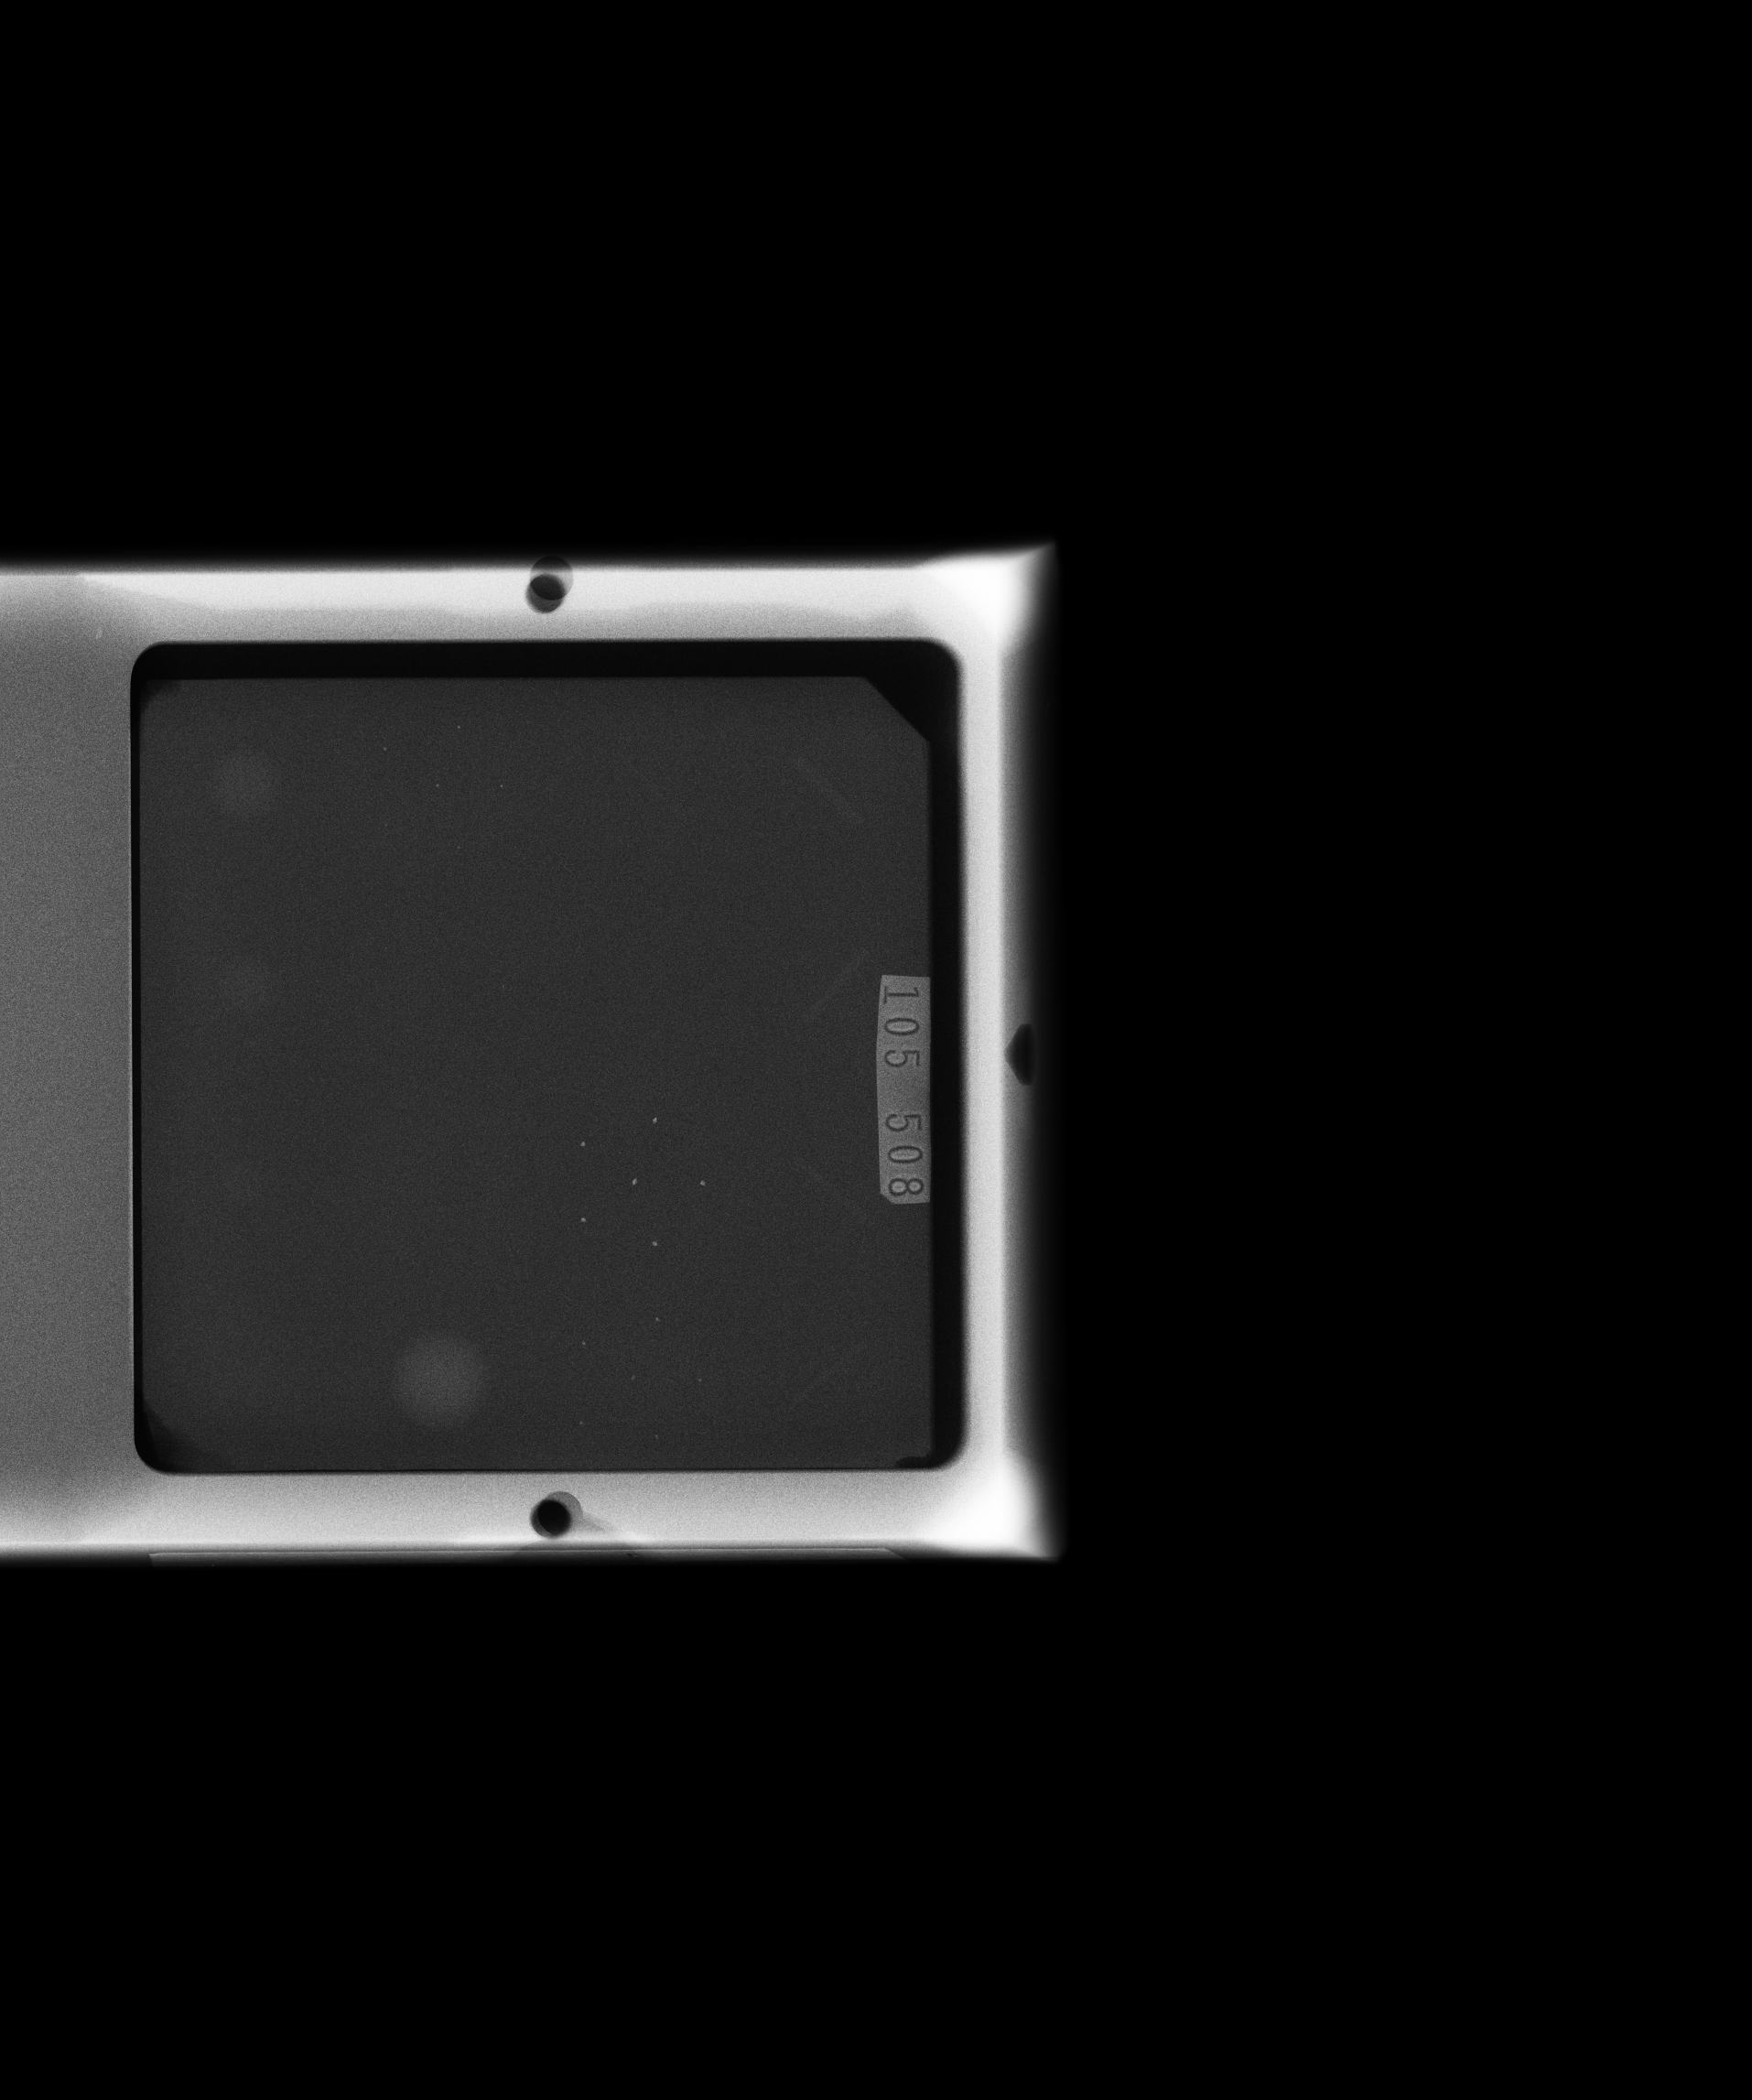

In [22]:
pixel_array = ds.pixel_array
Image.fromarray(_pixel_process(ds,pixel_array))

In [182]:
pixel_array = ds.pixel_array
pixel_array = apply_modality_lut(pixel_array,ds)
pixel_array = apply_voi_lut(pixel_array, ds, prefer_lut=True)
pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
if 'PhotometricInterpretation' in ds and ds.PhotometricInterpretation == "MONOCHROME1":
        # NOT add minus directly
    pixel_array = np.max(pixel_array) - pixel_array
Image.fromarray(pixel_array.astype('uint8')).show()


In [10]:
# LINEAR EXACT

def _get_LUT_value(data, window, level):
    """
    Adjust according to LUT, window center(level) and width values
    """
    # xxx=np.piecewise(x, [condition1,condition2], [func1,func2])
    data = np.piecewise(data, 
        [data<=(level-(window)/2),
        data>(level+(window)/2)],
        [0,255,lambda data: ((data-level+window/2)/window*255)])
    #data = np.clip(data, a_min=0, a_max=255)
    return np.clip(data, a_min=0, a_max=255)
                        

In [90]:
## LINEAR
def _get_LUT_value(data, window, level):
    """
    Adjust according to LUT, window center(level) and width values
    """
    # xxx=np.piecewise(x, [condition1,condition2], [func1,func2])
    return np.piecewise(data, 
        [data<=(level-0.5-(window-1)/2),
        data>(level-0.5+(window-1)/2)],
        [0,255,lambda data: ((data-(level-0.5))/(window-1)+0.5)*(255-0)])

from pydicom.pixel_data_handlers.util import apply_voi_lut
# pixel_array = apply_voi_lut(ds.pixel_array, ds)

In [91]:
Image.fromarray(_pixel_process(ds,pixel_array)).show()

## 0.1.3 support list of files and folders

In [1]:
import test_version

In [6]:
tf = r'/Users/yukuo/Desktop/dicom_test/'

In [7]:
import dicom2jpg

In [8]:
test_version.dicom2jpg(tf,tf)

True

In [59]:
def _get_root_get_dicom_file_list(origin_input, target_root):
    """
    Process origin_input
    if it is a list/tuple -> iterate through all the element
    
    return target root_folder 
    - if specified, return Path object of target_root
    - if unspecified, return parent folder of the first element in origin_input
    return dicom_file_list
    """
    # if single file, return root folder of origin file and a list of that file
    
    # if it is in list or tuple -> iterate through items
    # origin_list is a list, containing folders and files as Path type
    if isinstance(origin_input, list) or isinstance(origin_input, tuple):
        origin_list = [Path(ori) for ori in origin_input]  # make all items as path
    else:
        origin_list = [Path(origin_input)]
    dicom_file_list = []
    
    # check file/folder existance and if they are dicom files
    # if file or folder does not exist
    for origin in origin_list:
        if not origin.exists():
            raise OSError(f"File or folder '{origin}' does not exist")
        # if it is a file, then check if it's a dicom and add it to dicom_file_list
        if origin.is_file():
            if origin.suffix.lower()!='.dcm':
                raise Exception('Input file type should be a DICOM file')
            else:
                dicom_file_list.append(origin)
        # if it is a dir, then add all the dicom files into dicom_file_list
        elif origin.is_dir():
            for root, sub_f, file in os.walk(origin):
                for f in file:
                    if f.lower().endswith('.dcm'):
                        file_path_dcm = Path(root)/Path(f)
                        # file_path_exp =  folder_destination / Path(f).with_suffix('.jpg')
                        # stor origin / destination
                        dicom_file_list.append(file_path_dcm)
    # sort the list
    dicom_file_list.sort()
        
    # set root_folder
    # if target root is not specified, set as same root of origin file 
    if target_root is None:
        if isinstance(origin_input, list) or isinstance(origin_input, tuple):
            # list or tuple -> the first element location
            root_folder = Path(origin_input[0]).parent
        else:
            # single folder or file
            root_folder = Path(origin_input).parent
    else:
        root_folder = Path(target_root)
    return root_folder, dicom_file_list

## 0.1.0 multiprocessing and anomynous file name


598mb 1873 files (mixed with X-ray, CT, MR)
CPU
> {'CT': 1528, 'CR': 52, 'MR': 174, 'DX': 36}
> Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz
> 4 Cores (hyper-threading off)
> Tested on Ramdisk

multiprocessing=False, anonymous=True -> 154.6 / 159.7
multiprocessing=True, anonymous=True -> 79.2 / 82.9
multiprocessing=False, anonymous=False -> 162.8 / 157.9
multiprocessing=True, anonymous=False -> 56 / 58.5

In [16]:
from pathlib import Path
import os
import time
import concurrent.futures
import pydicom

fl = get_root_get_dicom_file_list(r"E:")[1]
len(fl)

_get_anonymous_full_path_dict(fl, Path(r"E:"),'jpg')

1873

In [30]:
def _get_anonymous_full_path_dict(dicom_file_list, target_root, file_type):
    patient_dict = {'last_pt_num':0}
    full_path_dict = {}
    for file_path in dicom_file_list:
        ds = pydicom.dcmread(file_path, stop_before_pixels=False)
        # get metadata
        try:
            AccessionNumber = ds.AccessionNumber  # Acc number
        except:
            AccessionNumber = 'UnknownAccNum'
        try:
            Modality = ds.Modality  # modality
        except:
            Modality = 'UnknownModality'
        try:
            PatientID = ds.PatientID  # patient id
        except:
            PatientID = 'UnknownID'
        try:
            SeriesNumber = ds.SeriesNumber  # series number
        except:
            SeriesNumber = 'Ser'
        try:
            InstanceNumber = ds.InstanceNumber
        except:
            InstanceNumber = 'Ins'

            # if new patient -> write patient ID
        if PatientID not in patient_dict:
            patient_dict['last_pt_num']+=1
            patient_dict[PatientID] = {}
            patient_dict[PatientID]['patient_num'] = patient_dict['last_pt_num']
            patient_dict[PatientID]['unknown_file'] = 0
            patient_dict[PatientID]['last_study_num'] = 0

        if AccessionNumber not in patient_dict[PatientID]:
            patient_dict[PatientID]['last_study_num']+=1
            patient_dict[PatientID][AccessionNumber] = patient_dict[PatientID]['last_study_num']

        # if new patient -> write patient ID
        if PatientID not in patient_dict:
            patient_dict['last_pt_num']+=1
            patient_dict[PatientID] = {}
            patient_dict[PatientID]['patient_num'] = patient_dict['last_pt_num']
            patient_dict[PatientID]['unknown_file'] = 0
            patient_dict[PatientID]['last_study_num'] = 0

        if AccessionNumber not in patient_dict[PatientID]:
            patient_dict[PatientID]['last_study_num']+=1
            patient_dict[PatientID][AccessionNumber] = patient_dict[PatientID]['last_study_num']

        # if any unknown components
        is_unknown_file = AccessionNumber=='UnknownAccNum' or \
                            Modality == 'UnknownModality' or \
                            PatientID == 'UnknownID' or \
                            SeriesNumber == 'Ser' or \
                            InstanceNumber == 'Ins'

        # patient folder and study folder
        patient_folder_name = f"Patient_{patient_dict[PatientID]['patient_num']}"
        study_folder_name = f"{patient_dict[PatientID][AccessionNumber]}_{Modality}"
        # file name. if any unknown components -> use unknown file count
        if is_unknown_file:
            patient_dict[PatientID]['unknown_file']+=1
            file_name = f"img_{patient_dict[PatientID]['unknown_file']}.{file_type}"
        else:
            file_name = f"{SeriesNumber}_{InstanceNumber}.{file_type}"
        # date
        today_str = time.strftime('%Y%m%d')

        full_file_path = target_root / Path(today_str) / Path(patient_folder_name) / Path(study_folder_name) / Path(file_name)

        full_path_dict[file_path] = full_file_path
        
    return full_path_dict

def get_root_get_dicom_file_list(origin):
    # if single file, return root folder of origin file and a list of that file
    origin = Path(origin)
    dicom_file_list = []
    
    # if file or folder does not exist
    if not origin.exists():
        raise OSError('File or folder does not exist')
    # if it is a file
    if origin.is_file():
        if origin.suffix.lower()!='.dcm':
            raise Exception('Input file type should be a DICOM file')
        else:
            dicom_file_list = [origin]
            root_folder = origin.parent
    # if it is a folder
    else:
        # read file
        for root, sub_f, file in os.walk(origin):
            for f in file:
                if f.lower().endswith('.dcm'):
                    file_path_dcm = Path(root)/Path(f)
                    # file_path_exp =  folder_destination / Path(f).with_suffix('.jpg')
                    # stor origin / destination
                    dicom_file_list.append(file_path_dcm)
        # sort the list
        dicom_file_list.sort()
        # root folder
        root_folder = origin.parent
    return root_folder, dicom_file_list

In [1]:
import timeit
import time
import pydicom


In [2]:
import timeit
import test_version

In [ ]:
%%timeit
test_version.dicom2jpg(r'E:', r'E:\FT', multiprocessing=False, anonymous=True)

In [ ]:
%%timeit
test_version.dicom2jpg(r'E:', r'E:\FF', multiprocessing=False, anonymous=False)


In [7]:
start = time.time()
test_version.dicom2tiff(r'E:', r'E:\TT', multiprocessing=True, anonymous=True)
print(time.time()-start)

80.06176733970642


In [8]:
start = time.time()
test_version.dicom2tiff(r'E:', r'E:\TT', multiprocessing=True, anonymous=False)
print(time.time()-start)

50.73589587211609


## 0.0.9 BytesIO to img, test

In [11]:
import test_version
import io
with open(r"/Users/yukuo/Desktop/dicom_test/color.dcm",'rb') as f:
    dcm_io = io.BytesIO(f.read())

In [12]:
px = test_version.io2img(dcm_io)

In [ ]:
from PIL import Image
# plt display is using RGB format, so it is normal
display(Image.fromarray(px))

## Issue overlay image, eg. dose report

In [ ]:
# Digital Imaging and Communications in Medicine (DICOM), book


# dicom
# http://dicom.nema.org/dicom/2013/output/chtml/part03/sect_C.9.html
# pydicom
# https://pydicom.github.io/pydicom/dev/old/working_with_overlays.html

# discussion about overlay
# https://stackoverflow.com/questions/36685561/dicom-why-need-overlay-and-how-to-read-it



# how many overlays
# https://www.medicalconnections.co.uk/kb/number-of-overlays-in-image/


In [3]:
ds = pydicom.dcmread(Path(r'E:\dcm_test_bank\dose_info.dcm', ), force=True)
pixel_array = ds.pixel_array
num_of_frame_in_overlay = ds[0x6000,0x0015].value  # 1 

# overlay_data = ds[0x6000, 0x3000].value
overlay_data = ds.overlay_array(0x6000)  # overlay -> ndarray
overlay_data.shape  # len ==2

NameError: name 'pydicom' is not defined

In [ ]:


def _render_overly(ds, original_pixels):
    # orignal pixels should be float, to prevent overflow
    
    num_of_frame_in_overlay = ds[0x6000,0x0015].value  # 1 
    # currently only support 1 overlay ()
    if num_of_frame_in_overlay!=1:
        return original_pixels
    
    # overlay_data = ds[0x6000, 0x3000].value
    overlay_data = ds.overlay_array(0x6000)  # overlay -> ndarray
    overlay_data.shape  # len ==2
    overlay_origin = ds[0x6000,0x0050].value  # assume to be [1,1]
    
    original_pixels = original_pixels+ overlay_data*255

In [70]:
overlay_origin = ds[0x6000,0x0050].value 
overlay_origin

[1, 1]

In [67]:
a = np.array([1,2,3,4,5]).astype('uint8')
b = np.array([1,2,3,4,255]).astype('uint8')
z = np.ones(5)*5
c = np.minimum(a+b, 255)
c

array([2, 4, 6, 8, 4], dtype=uint8)

In [48]:

pixel_array = pixel_array+ overlay_data*255
display(Image.fromarray(np.uint8(pixel_array)))

In [ ]:
# image = cv2.resize(image, (256, 256), interpolation=cv2.LINEAR)  # if want to resize

## Issue: Support Fluoroscopic image

In [4]:
# utils.py

import pydicom
import cv2
import numpy as np
from pathlib import Path
import os
from pydicom.pixel_data_handlers.util import apply_voi_lut
import time


def dicom2jpg(origin, target_root=None, filetype=None):
    """
    origin: can be a .dcm file or a folder
    target_root: root of output files and folders; default: root of origin file or folder
    filetype: can be jpg, jpeg, png, or bmp
    full target file path = target_root/Today/PatientID_filetype/StudyDate_StudyTime_Modality_AccNum/Ser_Img.filetype
    """
    # set file type
    if filetype is None:
        filetype = 'jpg'
    elif filetype.lower() not in ['jpg','png','jpeg', 'bmp']:
        raise Exception('Target file type should be jpg, png, or bmp')
    
    # get root folder and dicom_file_list
    root_folder, dicom_file_list = get_root_get_dicom_file_list(origin)

    # if target root is not specified, set as same root of origin file 
    if target_root is None:
        target_root = root_folder
    else:
        target_root = Path(target_root)

    # Iterate through all dicom files
    for file_path in dicom_file_list:
        # read images and their pixel data
        ds = pydicom.dcmread(file_path, force=True)
        
        # to exclude unsupported SOP class by its UID
        # PDF
        if ds.SOPClassUID == '1.2.840.10008.5.1.4.1.1.104.1':
            print('SOP class - 1.2.840.10008.5.1.4.1.1.104.1(Encapsulated PDF Storage) is not supported')
            continue
        
        # convert pixel_array (img) to -> gray image 
        pixel_array = ds.pixel_array.astype(float)  # preparing for scaling
        
        # if fluro movie -> call function recurssively and then pass
        # if pixel_array.shape[2]==3 -> means color files
        if len(pixel_array.shape)==3 and pixel_array.shape[2]!=3:
            print('Fluoroscopic images...')
            continue

        # rescale slope and intercept first, then adjust window center/width
        # rescale slope, rescale intercept, adjust window and level
        try:
            # cannot use INT, because resale slope could be<1 
            rescale_slope = ds.RescaleSlope # int(ds.RescaleSlope)
            rescale_intercept = ds.RescaleIntercept #  int(ds.RescaleIntercept)
            pixel_array = (pixel_array)*rescale_slope+rescale_intercept
        except:
            pass

        # Adjust according to LUT, window center(level) and width values
        # xxx=np.piecewise(x, [condition1,condition2], [func1,func2])
        def get_LUT_value(data, window, level):
            return np.piecewise(data, 
                [data<=(level-0.5-(window-1)/2),
                data>(level-0.5+(window-1)/2)],
                [0,255,lambda data: ((data-(level-0.5))/(window-1)+0.5)*(255-0)])

        # get window center and window width value
        try:
            window_center = ds.WindowCenter
            window_width = ds.WindowWidth
            # some values may be stored in an array
            if type(window_center)==pydicom.multival.MultiValue:
                window_center = int(window_center[0])
            else:
                window_center = int(window_center)
            if type(window_width)==pydicom.multival.MultiValue:
                window_width = int(window_width[0])
            else:
                window_width = int(window_width)
            pixel_array = get_LUT_value(pixel_array, window_width, window_center)
        except:
        # if there is no window center, window width tag, try obtaining VOI LUT setting (usually happens to plain films)
            try:
                if ds.VOILUTSequence:
                    pixel_array = apply_voi_lut(ds.pixel_array, ds)
            except:
                pass

        # normalize to 8bit information
        # Conver to uint8 (8-bit unsigned integer), for image to save/display
        # almost no difference. However, this formula yeild slightly more standard deviation 
        pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0

        # These 2 formula are the same
        # pixel_array = (np.maximum(pixel_array,0) / pixel_array.max()) * 255.0
        #pixel_array = pixel_array - np.min(pixel_array)
        #pixel_array = pixel_array / np.max(pixel_array)
        #pixel_array = (pixel_array*255).astype(np.uint8)

        # if PhotometricInterpretation == "MONOCHROME1", then inverse; eg. xrays
        try:
            if ds.PhotometricInterpretation == "MONOCHROME1":
            # if ds.PresentationLUTShape=='INVERSE':  # not always be shown
            # NOT add minus directly
                pixel_array = np.max(pixel_array) - pixel_array
        except:
            pass
        
        # Try to get metadata        
        try:
            StudyDate = ds.StudyDate  # study date
        except:
            StudyDate = 'UnknownDate'
        try:
            StudyTime = ds.StudyTime.split('.')[0] # study time
        except:
            StudyTime = 'UnknownTime'
        try:
            AccessionNumber = ds.AccessionNumber  # Acc number
        except:
            AccessionNumber = 'UnknownAccNum'
        try:
            Modality = ds.Modality  # modality
        except:
            Modality = 'UnknownModality'
        try:
            PatientID = ds.PatientID  # patient id
        except:
            PatientID = 'UnknownID'
        try:
            SeriesNumber = ds.SeriesNumber  # series number
        except:
            SeriesNumber = 'Ser'
        try:
            InstanceNumber = ds.InstanceNumber
        except:
            InstanceNumber = 'Ins'
            
        # Full export file path
        # target_root/Today/PatientID_filetype/StudyDate_StudyTime_Modality_AccNum/Ser_Img.filetype
        today_str = time.strftime('%Y%m%d')
        full_export_fp_fn = target_root/Path(today_str)/Path(f"{PatientID}_{filetype}")/Path(f"{StudyDate}_{StudyTime}_{Modality}_{AccessionNumber}")/Path(f"{SeriesNumber}_{InstanceNumber}.{filetype}")
        # make dir
        Path.mkdir(full_export_fp_fn.parent, exist_ok=True, parents=True)
        # write file
        
        # if YBR_RCT and RGB data should be convert to BGR and then be converted
        try:
            # or use if pixel_array.shape[2]==3 , eg. (1754, 1240, 3)
            if ds.PhotometricInterpretation=='YBR_RCT' or ds.PhotometricInterpretation=='RGB':
                cv2.imwrite(str(full_export_fp_fn), cv2.cvtColor(np.float32(pixel_array), cv2.COLOR_RGB2BGR))
            else:
                cv2.imwrite(str(full_export_fp_fn), pixel_array)
        except:
            cv2.imwrite(str(full_export_fp_fn), pixel_array)
        


def get_root_get_dicom_file_list(origin):
    # if single file, return root folder of origin file and a list of that file
    origin = Path(origin)
    dicom_file_list = []
    
    # if file or folder does not exist
    if not origin.exists():
        raise OSError('File or folder does not exist')
    # if it is a file
    if origin.is_file():
        if origin.suffix.lower()!='.dcm':
            raise Exception('Input file type should be a DICOM file')
        else:
            dicom_file_list = [origin]
            root_folder = origin.parent
    # if it is a folder
    else:
        # read file
        for root, sub_f, file in os.walk(origin):
            for f in file:
                if f.lower().endswith('.dcm'):
                    file_path_dcm = Path(root)/Path(f)
                    # file_path_exp =  folder_destination / Path(f).with_suffix('.jpg')
                    # stor origin / destination
                    dicom_file_list.append(file_path_dcm)
        # sort the list
        dicom_file_list.sort()
        # root folder
        root_folder = origin.parent
    return root_folder, dicom_file_list



## 20210604 Fix for wrong colors, Fix slope and intercept, Fix error while reading other types of files

In [172]:
test = Path(r"E:\Temp")

In [21]:
dicom2jpg("/Users/yukuo/Desktop/dicom_test/test.dcm", filetype='jpeg')

In [2]:
def dicom2jpg(origin, target_root=None, filetype=None):
    """
    origin: can be a .dcm file or a folder
    target_root: root of output files and folders; default: root of origin file or folder
    filetype: can be jpg, jpeg, png, or bmp
    full target file path = target_root/Today/PatientID_filetype/StudyDate_StudyTime_Modality_AccNum/Ser_Img.filetype
    """
    # set file type
    if filetype is None:
        filetype = 'jpg'
    elif filetype.lower() not in ['jpg','png','jpeg', 'bmp']:
        raise Exception('Target file type should be jpg, png, or bmp')
    
    # get root folder and dicom_file_list
    root_folder, dicom_file_list = get_root_get_dicom_file_list(origin)

    # if target root is not specified, set as same root of origin file 
    if target_root is None:
        target_root = root_folder
    else:
        target_root = Path(target_root)

    # Iterate through all dicom files
    for file_path in dicom_file_list:
        # read images and their pixel data
        ds = pydicom.dcmread(file_path, force=True)
        
        # to exclude unsupported SOP class by its UID
        # PDF
        if ds.SOPClassUID == '1.2.840.10008.5.1.4.1.1.104.1':
            print('SOP class - 1.2.840.10008.5.1.4.1.1.104.1(Encapsulated PDF Storage) is not supported')
            continue
        
        # convert pixel_array (img) to -> gray image 
        pixel_array = ds.pixel_array.astype(float)  # preparing for scaling
        
        # if fluro movie -> call function recurssively and then pass
        # if pixel_array.shape[2]==3 -> means color files
        if len(pixel_array.shape)==3 and pixel_array.shape[2]!=3:
            print('Fluoroscopic images...')
            continue

        # rescale slope and intercept first, then adjust window center/width
        # rescale slope, rescale intercept, adjust window and level
        try:
            # cannot use INT, because resale slope could be<1 
            rescale_slope = ds.RescaleSlope # int(ds.RescaleSlope)
            rescale_intercept = ds.RescaleIntercept #  int(ds.RescaleIntercept)
            pixel_array = (pixel_array)*rescale_slope+rescale_intercept
        except:
            pass

        # Adjust according to LUT, window center(level) and width values
        # xxx=np.piecewise(x, [condition1,condition2], [func1,func2])
        def get_LUT_value(data, window, level):
            return np.piecewise(data, 
                [data<=(level-0.5-(window-1)/2),
                data>(level-0.5+(window-1)/2)],
                [0,255,lambda data: ((data-(level-0.5))/(window-1)+0.5)*(255-0)])

        # get window center and window width value
        try:
            window_center = ds.WindowCenter
            window_width = ds.WindowWidth
            # some values may be stored in an array
            if type(window_center)==pydicom.multival.MultiValue:
                window_center = int(window_center[0])
            else:
                window_center = int(window_center)
            if type(window_width)==pydicom.multival.MultiValue:
                window_width = int(window_width[0])
            else:
                window_width = int(window_width)
            pixel_array = get_LUT_value(pixel_array, window_width, window_center)
        except:
        # if there is no window center, window width tag, try obtaining VOI LUT setting (usually happens to plain films)
            try:
                if ds.VOILUTSequence:
                    pixel_array = apply_voi_lut(ds.pixel_array, ds)
            except:
                pass

        # normalize to 8bit information
        # Conver to uint8 (8-bit unsigned integer), for image to save/display
        # almost no difference. However, this formula yeild slightly more standard deviation 
        pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0

        # These 2 formula are the same
        # pixel_array = (np.maximum(pixel_array,0) / pixel_array.max()) * 255.0
        #pixel_array = pixel_array - np.min(pixel_array)
        #pixel_array = pixel_array / np.max(pixel_array)
        #pixel_array = (pixel_array*255).astype(np.uint8)

        # if PhotometricInterpretation == "MONOCHROME1", then inverse; eg. xrays
        try:
            if ds.PhotometricInterpretation == "MONOCHROME1":
            # if ds.PresentationLUTShape=='INVERSE':  # not always be shown
            # NOT add minus directly
                pixel_array = np.max(pixel_array) - pixel_array
        except:
            pass
        
        # Try to get metadata        
        try:
            StudyDate = ds.StudyDate  # study date
        except:
            StudyDate = 'UnknownDate'
        try:
            StudyTime = ds.StudyTime.split('.')[0] # study time
        except:
            StudyTime = 'UnknownTime'
        try:
            AccessionNumber = ds.AccessionNumber  # Acc number
        except:
            AccessionNumber = 'UnknownAccNum'
        try:
            Modality = ds.Modality  # modality
        except:
            Modality = 'UnknownModality'
        try:
            PatientID = ds.PatientID  # patient id
        except:
            PatientID = 'UnknownID'
        try:
            SeriesNumber = ds.SeriesNumber  # series number
        except:
            SeriesNumber = 'Ser'
        try:
            InstanceNumber = ds.InstanceNumber
        except:
            InstanceNumber = 'Ins'
            
        # Full export file path
        # target_root/Today/PatientID_filetype/StudyDate_StudyTime_Modality_AccNum/Ser_Img.filetype
        today_str = time.strftime('%Y%m%d')
        full_export_fp_fn = target_root/Path(today_str)/Path(f"{PatientID}_{filetype}")/Path(f"{StudyDate}_{StudyTime}_{Modality}_{AccessionNumber}")/Path(f"{SeriesNumber}_{InstanceNumber}.{filetype}")
        # make dir
        Path.mkdir(full_export_fp_fn.parent, exist_ok=True, parents=True)
        # write file
        
        # if YBR_RCT and RGB data should be convert to BGR and then be converted
        try:
            # or use if pixel_array.shape[2]==3 , eg. (1754, 1240, 3)
            if ds.PhotometricInterpretation=='YBR_RCT' or ds.PhotometricInterpretation=='RGB':
                cv2.imwrite(str(full_export_fp_fn), cv2.cvtColor(np.float32(pixel_array), cv2.COLOR_RGB2BGR))
            else:
                cv2.imwrite(str(full_export_fp_fn), pixel_array)
        except:
            cv2.imwrite(str(full_export_fp_fn), pixel_array)
        


def get_root_get_dicom_file_list(origin):
    # if single file, return root folder of origin file and a list of that file
    origin = Path(origin)
    dicom_file_list = []
    
    # if file or folder does not exist
    if not origin.exists():
        raise OSError('File or folder does not exist')
    # if it is a file
    if origin.is_file():
        if origin.suffix.lower()!='.dcm':
            raise Exception('Input file type should be a DICOM file')
        else:
            dicom_file_list = [origin]
            root_folder = origin.parent
    # if it is a folder
    else:
        # read file
        for root, sub_f, file in os.walk(origin):
            for f in file:
                if f.lower().endswith('.dcm'):
                    file_path_dcm = Path(root)/Path(f)
                    # file_path_exp =  folder_destination / Path(f).with_suffix('.jpg')
                    # stor origin / destination
                    dicom_file_list.append(file_path_dcm)
        # sort the list
        dicom_file_list.sort()
        # root folder
        root_folder = origin.parent
    return root_folder, dicom_file_list


## 20210603 Function

In [1]:

def get_root_get_dicom_file_list(origin):
    # if single file, return root folder of origin file and a list of that file
    origin = Path(origin)
    dicom_file_list = []
    
    # if file or folder does not exist
    if not origin.exists():
        raise OSError('File or folder does not exist')
    # if it is a file
    if origin.is_file():
        if origin.suffix.lower()!='.dcm':
            raise Exception('Input file type should be a DICOM file')
        else:
            dicom_file_list = [origin]
            root_folder = origin.parent
    # if it is a folder
    else:
        # read file
        for root, sub_f, file in os.walk(origin):
            for f in file:
                if f.lower().endswith('.dcm'):
                    file_path_dcm = Path(root)/Path(f)
                    # file_path_exp =  folder_destination / Path(f).with_suffix('.jpg')
                    # stor origin / destination
                    dicom_file_list.append(file_path_dcm)
        # sort the list
        dicom_file_list.sort()
        # root folder
        root_folder = origin.parent
    return root_folder, dicom_file_list


def dicom2jpg(origin, target_root=None, filetype=None):
    """
    origin: can be a .dcm file or a folder
    target_root: root of output files and folders; default: root of origin file or folder
    filetype: can be jpg, jpeg, tiff, png, or bmp
    full target file path = target_root/Today/PatientID_filetype/StudyDate_StudyTime_Modality_AccNum/Ser_Img.filetype
    """
    # set file type
    if filetype is None:
        filetype = 'jpg'
    elif filetype.lower() not in ['jpg','tiff','png', 'jpeg', 'bmp']:
        raise Exception('Target file type should be jpg, tiff, png, or bmp')
    
    # get root folder and dicom_file_list
    root_folder, dicom_file_list = get_root_get_dicom_file_list(origin)

    # if target root is not specified, set as same root of origin file 
    if target_root is None:
        target_root = root_folder
    else:
        target_root = Path(target_root)

    # Iterate through all dicom files
    for file_path in dicom_file_list:
        # read images and their pixel data
        ds = pydicom.dcmread(file_path, force=True)
        # convert pixel_array (img) to -> gray image 
        # Need JPEG 2000 plugin for pillow
        pixel_array = ds.pixel_array.astype(float)  # preparing for scaling

        # rescale slope, rescale intercept, adjust window and level
        try:
            rescale_slope = int(ds.RescaleSlope)
            rescale_intercept = int(ds.RescaleIntercept)
            pixel_array = (pixel_array)*rescale_slope+rescale_intercept
        except:
            pass

        # Adjust according to LUT, window center(level) and width values
        # xxx=np.piecewise(x, [condition1,condition2], [func1,func2])
        def get_LUT_value(data, window, level):
            return np.piecewise(data, 
                [data<=(level-0.5-(window-1)/2),
                data>(level-0.5+(window-1)/2)],
                [0,255,lambda data: ((data-(level-0.5))/(window-1)+0.5)*(255-0)])

        # get window center and window width value
        try:
            window_center = ds.WindowCenter
            window_width = ds.WindowWidth
            # some values may be stored in an array
            if type(window_center)==pydicom.multival.MultiValue:
                window_center = int(window_center[0])
            else:
                window_center = int(window_center)
            if type(window_width)==pydicom.multival.MultiValue:
                window_width = int(window_width[0])
            else:
                window_width = int(window_width)
            pixel_array = get_LUT_value(pixel_array, window_width, window_center)
        except:
        # if there is no window center, window width tag, try obtaining VOI LUT setting (usually happens to plain films)
            try:
                if ds.VOILUTSequence:
                    pixel_array = apply_voi_lut(ds.pixel_array, ds)
            except:
                pass

        # normalize to 8bit information
        # Conver to uint8 (8-bit unsigned integer), for image to save/display
        # almost no difference. However, this formula yeild slightly more standard deviation 
        pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0

        # These 2 formula are the same
        # pixel_array = (np.maximum(pixel_array,0) / pixel_array.max()) * 255.0
        #pixel_array = pixel_array - np.min(pixel_array)
        #pixel_array = pixel_array / np.max(pixel_array)
        #pixel_array = (pixel_array*255).astype(np.uint8)

        # if PhotometricInterpretation == "MONOCHROME1", then inverse; eg. xrays
        try:
            if ds.PhotometricInterpretation == "MONOCHROME1":
            # if ds.PresentationLUTShape=='INVERSE':  # not always be shown
            # NOT add minus directly
                pixel_array = np.max(pixel_array) - pixel_array
        except:
            pass
        
        # Try to get metadata        
        try:
            StudyDate = ds.StudyDate  # study date
        except:
            StudyDate = 'UnknownDate'
        try:
            StudyTime = ds.StudyTime.split('.')[0] # study time
        except:
            StudyTime = 'UnknownTime'
        try:
            AccessionNumber = ds.AccessionNumber  # Acc number
        except:
            AccessionNumber = 'UnknownAccNum'
        try:
            Modality = ds.Modality  # modality
        except:
            Modality = 'UnknownModality'
        try:
            PatientID = ds.PatientID  # patient id
        except:
            PatientID = 'UnknownID'
        try:
            SeriesNumber = ds.SeriesNumber  # series number
        except:
            SeriesNumber = 'Ser'
        try:
            InstanceNumber = ds.InstanceNumber
        except:
            InstanceNumber = 'Ins'
            
        # Full export file path
        # target_root/Today/PatientID_filetype/StudyDate_StudyTime_Modality_AccNum/Ser_Img.filetype
        today_str = time.strftime('%Y%m%d')
        full_export_fp_fn = target_root/Path(today_str)/Path(f"{PatientID}_{filetype}")/Path(f"{StudyDate}_{StudyTime}_{Modality}_{AccessionNumber}")/Path(f"{SeriesNumber}_{InstanceNumber}.{filetype}")
        # make dir
        Path.mkdir(full_export_fp_fn.parent, exist_ok=True, parents=True)
        # write file
        cv2.imwrite(str(full_export_fp_fn), pixel_array)




## Function test

### YBR_RCT to BGR
cannot use

In [ ]:
# converting 'YBR_RCT' to 'BGR', for cv2 to export
# ds.PhotometricInterpretation : 'YBR_RCT'
Y_CB_CR = ds.pixel_array
RGB = np.zeros(Y_CB_CR.shape)# .astype(np.float)
Y = Y_CB_CR[:,:,0]
CB = Y_CB_CR[:,:,1]
CR = Y_CB_CR[:,:,2]
G = Y - np.floor((CR+CB)/4) # G = Y - ⌊ (CR+ CB) / 4⌋
R = CR + G  # R = CR+ G
B = CB + G  # B = CB+ G
RGB[:,:,0] = B
RGB[:,:,1] = G
RGB[:,:,2] = R
display(Image.fromarray(np.uint8(RGB)))

### Conversion function

In [216]:
for file_path in dicom_file_list[:20]:
    # read images and their pixel data
    ds = pydicom.dcmread(file_path, force=True)
    # convert pixel_array (img) to -> gray image 
    # Need JPEG 2000 plugin for pillow
    pixel_array = ds.pixel_array.astype(float)  # preparing for scaling
    
    # rescale slope, rescale intercept, adjust window and level
    try:
        rescale_slope = int(ds.RescaleSlope)
        rescale_intercept = int(ds.RescaleIntercept)
        pixel_array = (pixel_array)*rescale_slope+rescale_intercept
    except:
        pass

    # Adjust according to LUT, window center(level) and width values
    # xxx=np.piecewise(x, [condition1,condition2], [func1,func2])
    def get_LUT_value(data, window, level):
        return np.piecewise(data, 
            [data<=(level-0.5-(window-1)/2),
            data>(level-0.5+(window-1)/2)],
            [0,255,lambda data: ((data-(level-0.5))/(window-1)+0.5)*(255-0)])
    
    # get window center and window width value
    try:
        window_center = ds.WindowCenter
        window_width = ds.WindowWidth
        # some values may be stored in an array
        if type(window_center)==pydicom.multival.MultiValue:
            window_center = int(window_center[0])
        else:
            window_center = int(window_center)
        if type(window_width)==pydicom.multival.MultiValue:
            window_width = int(window_width[0])
        else:
            window_width = int(window_width)
        pixel_array = get_LUT_value(pixel_array, window_width, window_center)
    except:
    # if there is no window center, window width tag, try obtaining VOI LUT setting (usually happens to plain films)
        try:
            if ds.VOILUTSequence:
                pixel_array = apply_voi_lut(ds.pixel_array, ds)
        except:
            pass
        
    # normalize to 8bit information
    # Conver to uint8 (8-bit unsigned integer), for image to save/display
    # almost no difference
    # SD: 77.15839533934914
    pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
    
    # SD: 76.70618496373392
    # pixel_array = (np.maximum(pixel_array,0) / pixel_array.max()) * 255.0
    # SD: 77.15839533934914
    #pixel_array = pixel_array - np.min(pixel_array)
    #pixel_array = pixel_array / np.max(pixel_array)
    #pixel_array = (pixel_array*255).astype(np.uint8)
    
    # if PhotometricInterpretation == "MONOCHROME1", then inverse; eg. xrays
    try:
        if ds.PhotometricInterpretation == "MONOCHROME1":
        # if ds.PresentationLUTShape=='INVERSE':  # not always be shown
        # NOT add minus directly
            pixel_array = np.max(pixel_array) - pixel_array
    except:
        pass

    # export filepath/filename = folder_destination / full_file_name.dcm -> jpg/png/tiff/bmp
    full_export_fp_fn = folder_destination / file_path.with_suffix('.JPG').name
    # full_export_fp_fn = folder_destination / file_path.with_suffix('.png').name    
    # full_export_fp_fn = folder_destination / file_path.with_suffix('.tiff').name
    
    # make dir
    Path.mkdir(full_export_fp_fn.parent, exist_ok=True)
    # write file
    cv2.imwrite(str(full_export_fp_fn), pixel_array)
    



### Previous version

In [ ]:
# to figure out the pattern and relationship between VOI, LUT, window level/width
# some has VOI LUT, some has not
# some 
for file_path in dicom_file_list:
    ds = pydicom.dcmread(file_path, force=True)
    
    try:
        window_w = ds.WindowWidth
    except:
        window_w = 'x'
    try:
        window_c = ds.WindowCenter
    except:
        window_c = 'x'
    
    try:
        if ds.VOILUTSequence:
            voi_seq = '0'
        else:
            voi_seq = 'N'
    except:
        voi_seq='x'
        
    if ds.Modality=='CT' and type(ds.WindowWidth)==pydicom.multival.MultiValue:
        print(f'{ds.Modality} - window_w={window_w}, window_c={window_c}, {type(window_w)}, voi={voi_seq}')
        print(int(window_w[0]))
    
    # CR 如果沒有 window/center 必須要有 VOI sequence
    # CR 有 window/center 則通常沒有　voi
    # CT window/center 可以有　pydicom.multival.MultiValue or pydicom.valuerep.DSfloat
    # CT 沒在用 VOI

In [ ]:
# to solve VOI, LUT problem
# method in 
# https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way

# Get VOI LUT setting
try:
    if ds.VOILUTSequence:
        voi_lut = True
    else:
        voi_lut = False
except:
    voi_lut = False

# VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
if voi_lut:
    pixel_array = apply_voi_lut(ds.pixel_array, ds)
else:
    pixel_array = ds.pixel_array

# if PhotometricInterpretation == "MONOCHROME1", then inverse
try:
    if ds.PhotometricInterpretation == "MONOCHROME1":
    # if ds.PresentationLUTShape=='INVERSE':  # not necessary written
        pixel_array = np.amax(pixel_array) - pixel_array
except:
    pass
    
# scale to 255
pixel_array = pixel_array - np.min(pixel_array)
pixel_array = pixel_array / np.max(pixel_array)
pixel_array = (pixel_array * 255).astype(np.uint8)

display(Image.fromarray(np.uint8(pixel_array)))

In [ ]:
# Auto-convertor test function
# Need to solve the window/level/slope

dicom_file_list = dicom_file_list[:100]
# dicom_file_list = [Path('E:/Temp/General/000103436C/1.2.124.113532.10.21.11.4.20210601.113528.240164/1.3.51.0.7.13927215276.48758.24141.44523.34501.26226.49959/1.3.51.0.7.11650386957.16987.45636.41431.33978.40699.39256.dcm')]

for file_path in dicom_file_list:
    # read images and their pixel data
    ds = pydicom.dcmread(file_path, force=True)
    # # Convert pixel_array (img) to -> gray image (img_2d_scaled)
    # Pillow lacks the JPEG 2000 plugin
    # pip install pylibjpeg-libjpeg
    # pip install pylibjpeg pylibjpeg-libjpeg pydicom
    pixel_array = ds.pixel_array.astype(float)  # preparing for scaling

    
    # rescale slope, rescale intercept, adjust window and level
    try:
        rescale_slope = int(ds.RescaleSlope)
        rescale_intercept = int(ds.RescaleIntercept)
        pixel_array = (pixel_array)*rescale_slope+rescale_intercept
    except:
        pass

    # Adjust according to LUT
    # xxx=np.piecewise(x, [condition1,condition2], [func1,func2])
    # already 
    def get_LUT_value(data, window, level):
        return np.piecewise(data, 
            [data <= (level - 0.5 - (window-1)/2),
                data > (level - 0.5 + (window-1)/2)],
                [0, 255, lambda data: ((data - (level - 0.5))/(window-1) + 0.5)*(255-0)])
    
    # get window center and window width value
    try:
        window_center = int(ds.WindowCenter)
        window_width = int(ds.WindowWidth)
        pixel_array = get_LUT_value(pixel_array, window_width, window_center)
    except:
        pass
    
    
    
    # if inverse
    try:
        # inverse_sign = -1 if ds.PresentationLUTShape=='INVERSE' else 1
        inverse_sign = -1 if ds.PhotometricInterpretation == "MONOCHROME1" else 1
        pixel_array = inverse_sign * pixel_array  # *-1 is not good!! 
        # pixel_array = np.amax(pixel_array) - pixel_array is better 
    except:
        pass
    
    # Conver to uint8 (8-bit unsigned integer), for image to save/display
    # pixel_array_scaled = np.uint8(pixel_array)
    # Already done?
    
    # pixel_array_scaled = cv2.convertScaleAbs(pixel_array-np.min(pixel_array), alpha=(255.0 / min(np.max(pixel_array)-np.min(pixel_array), 10000)))
    # pixel_array_scaled = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
    
    # used in XRAY
    # pixel_array_scaled = (np.maximum(pixel_array, 0) / pixel_array.max()) * 255
    
    
    # export filepath/filename = folder_destination / full_file_name.dcm -> jpg
    full_export_fp_fn = folder_destination / file_path.with_suffix('.jpg').name

    # make dir
    Path.mkdir(full_export_fp_fn.parent, exist_ok=True)

    cv2.imwrite(str(full_export_fp_fn), pixel_array)
    


In [ ]:
# display CT file
# CT file use window/level, insead of VOI LUT to modify final image
# window/level may express in a list

ds = pydicom.dcmread(dicom_file_list[0], force=True)
pixel_array = ds.pixel_array.astype(float)  

# pixel_array = (pixel_array)*rescale_slope+rescale_intercept


# window center/level conversion function
# https://stackoverflow.com/questions/44924335/converting-12-bit-dicom-image-to-8-bit-jpeg
# http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.11.2.html#sect_C.11.2.1.2
def get_LUT_value(data, window, level):
    return np.piecewise(data, 
        [data <= (level - 0.5 - (window-1)/2),
            data > (level - 0.5 + (window-1)/2)],
            [0, 255, lambda data: ((data - (level - 0.5))/(window-1) + 0.5)*(255-0)])
pixel_array = get_LUT_value(pixel_array, window_width, window_center)


pixel_array =  (np.maximum(pixel_array, 0) / pixel_array.max()) * 255
#pixel_array = cv2.convertScaleAbs(pixel_array-window_center, alpha=(255.0/window_width))

display(Image.fromarray(np.uint8(pixel_array)))

In [ ]:
# use and tested this in XRAY
# Xray usually have window/level
# if no, have to add LUT transfer function
# if MONOCHROME1 -> have to inverse

# from matplotlib import pyplot as plt
ds = pydicom.dcmread(dicom_file_list[0], force=True)
pixel_array = ds.pixel_array.astype(float)  


# pixel_array = cv2.convertScaleAbs(pixel_array-np.min(pixel_array), alpha=(255.0 / min(np.max(pixel_array)-np.min(pixel_array), 10000)))
# pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
pixel_array =  (np.maximum(pixel_array, 0) / pixel_array.max()) * 255


# the use of Presentation LUT Shape == 'INVERSE' or PhotometricInterpretation == "MONOCHROME1"
# https://groups.google.com/g/comp.protocols.dicom/c/Wzt_06RbF5c?pli=1
# Presentation LUT Shape is mandatory in the DX Image Module
# Bottom line: both MONOCHROME2/IDENTITY and MONOCHROME1/INVERSE result in an output image where 0 is black and the maximum value is white (i.e. P-Values).
try:
    inverse_sign = -1 if ds.PresentationLUTShape=='INVERSE' else 1
    pixel_array = inverse_sign * pixel_array
except:
    pass
    
display(Image.fromarray(np.uint8(pixel_array)))

In [54]:
# But the contrast and 

dicom_file_list = dicom_file_list[:10]

for file_path in dicom_file_list:
    # read images and their pixel data
    ds = pydicom.dcmread(file_path)
    pixel_array = ds.pixel_array

    # export filepath/filename = folder_destination / full_file_name.dcm -> jpg
    full_export_fp_fn = folder_destination / file_path.with_suffix('.jpg').name

    # make dir
    Path.mkdir(full_export_fp_fn.parent, exist_ok=True)
    
    # export image
    cv2.imwrite(str(full_export_fp_fn), pixel_array)
    


In [2]:
from pydicom import dcmread
from pydicom.data import get_testdata_file

ds = dcmread(get_testdata_file('JPEG-LL.dcm'))
arr = ds.pixel_array

## Multiprocessing

In [1]:
import multiprocessing
cpus = multiprocessing.cpu_count()
cpus

8